# Import

In [ ]:
from pathlib import Path
import os
import sys

here = Path.cwd().resolve()
project_root = None

for p in [here] + list(here.parents):
    if (p / "src").exists() and (p / "pyproject.toml").exists():
        project_root = p
        break

if project_root is None:
    raise RuntimeError(
        f"Project root not found from {here}. "
    )

os.chdir(project_root)

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


✅ CWD set to project root: /home/clement/mnt/ssd_nvme/ai-med-portfolio/projects/dl/imaging/medical-image-diffusion
✅ data exists: True


In [19]:

import numpy as np 
import tqdm
import torch
# parent_root = Path.cwd().parent.parent
# project_root = os.path.join(parent_root, "src")
# sys.path.insert(0, str(project_root))
from pytorch_lightning import seed_everything
from accelerate import Accelerator
import matplotlib.pyplot as plt
import hydra

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize
import torch.nn.functional as F
from collections import defaultdict

from src.datamodule import DataModule_diff
from src.lightning_module import Modelelightning_diff


In [2]:
out_dir = Path("..") / "src"
data_dir = out_dir / "data"

# Def model/ datamodule

In [20]:
@hydra.main(config_path="config", config_name="config_diff", version_base="1.3")
def main(cfg: DictConfig):

    seed_everything(cfg.get("seed", 42), workers=True)

    cfg_data = cfg.data
    cfg_model = cfg.model

    datamodule = DataModule_diff(cfg_data)
    model = Modelelightning_diff(cfg_model)
    return model, datamodule


GlobalHydra.instance().clear()
config_path = os.path.join(out_dir, "config")

with initialize(version_base=None, config_path=config_path, job_name="nb"):
    cfg = compose(config_name="config_diff")
    model, datamodule = main(cfg)
    

Seed set to 42


In [21]:
datamodule.setup(stage="test")
test_loader = datamodule.test_dataloader()

In [23]:

ckpt_path = "checkpoints/best.ckpt"
model = Modelelightning_diff.load_from_checkpoint(
    ckpt_path,
    weights_only = False
)


In [24]:
accelerator = Accelerator(mixed_precision="bf16")
model = accelerator.prepare(
    model
)

model.eval()

Modelelightning_diff(
  (model): UNet2DModel(
    (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=64, out_features=256, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=256, out_features=256, bias=True)
    )
    (class_embedding): Embedding(6, 256)
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
            (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
     

# Test model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")  
test_loss = []   
with torch.no_grad():
    for batch in tqdm.tqdm(test_loader):
        x0 = batch["image"].to(device)
        class_id = batch["class_id"].to(device)
        bsz = x0.shape[0]

        noise = torch.randn_like(x0)
        t = torch.randint(
            0,
            model.noise_scheduler.config.num_train_timesteps,
            (bsz,),
            device=x0.device,
            dtype=torch.long,
        )

        xt = model.noise_scheduler.add_noise(x0, noise, t)
        eps_pred = model(xt, t, class_id)

        loss = F.mse_loss(eps_pred, noise) 
        test_loss.append(loss.cpu().numpy())
print(np.mean(test_loss))

100%|██████████| 513/513 [01:03<00:00,  8.12it/s]

0.01567677


In [27]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")  
sum_loss = defaultdict(float)
sum_count = defaultdict(int)
with torch.no_grad():
    for batch in tqdm.tqdm(test_loader):
        x0 = batch["image"].to(device)
        class_id = batch["class_id"].to(device)
        bsz = x0.shape[0]

        noise = torch.randn_like(x0)
        t = torch.randint(
            0,
            model.noise_scheduler.config.num_train_timesteps,
            (bsz,),
            device=x0.device,
            dtype=torch.long,
        )

        xt = model.noise_scheduler.add_noise(x0, noise, t)
        eps_pred = model(xt, t, class_id)

        per_sample = F.mse_loss(eps_pred, noise, reduction = "none").mean(dim=(1,2,3))
        for cls in class_id.unique():
            m = (class_id == cls)
            sum_loss[int(cls)] += per_sample[m].sum().item()
            sum_count[int(cls)] += int(m.sum().item())
        test_loss.append(loss.cpu().numpy())

for cls in sorted(sum_loss):
    print(f"class {cls}: {sum_loss[cls] / max(1,sum_count[cls]):.6f}  (n={sum_count[cls]})")

100%|██████████| 513/513 [01:03<00:00,  8.10it/s]

class 0: 0.015223  (n=6151)
class 1: 0.013205  (n=666)
class 2: 0.017889  (n=134)
class 3: 0.013635  (n=718)
class 4: 0.007949  (n=85)
class 5: 0.021002  (n=449)


In [ ]:

@torch.no_grad()
def sample_ddpm(model, class_id: int, n: int = 16, image_size: int = 256, in_channels: int = 1, device="cuda"):
    model.eval()

    x = torch.randn(n, in_channels, image_size, image_size, device=device)

    scheduler = model.noise_scheduler
    scheduler.set_timesteps(scheduler.config.num_train_timesteps, device=device)

    y = torch.full((n,), class_id, device=device, dtype=torch.long)

    for t in tqdm.tqdm(scheduler.timesteps):
        eps = model(x, t, y)  # forward: (x, t, class_id) -> eps
        # step inverse: x_{t-1}
        x = scheduler.step(eps, t, x).prev_sample

    return x  # [-1,1]


100%|██████████| 1000/1000 [02:01<00:00,  8.25it/s]


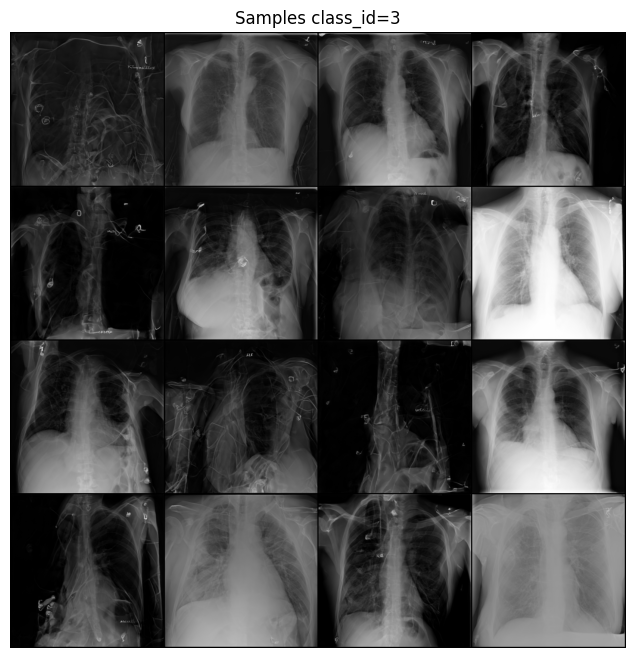

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_grid(x, nrow=4, title=""):
    # x: [-1,1] -> [0,1]
    x = (x.clamp(-1,1) + 1) / 2
    grid = torchvision.utils.make_grid(x, nrow=nrow)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

samples = sample_ddpm(model.to(device), class_id=3, n=16, image_size=256, in_channels=1, device=device)
show_grid(samples.cpu(), title="Samples class_id=3")
